In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql

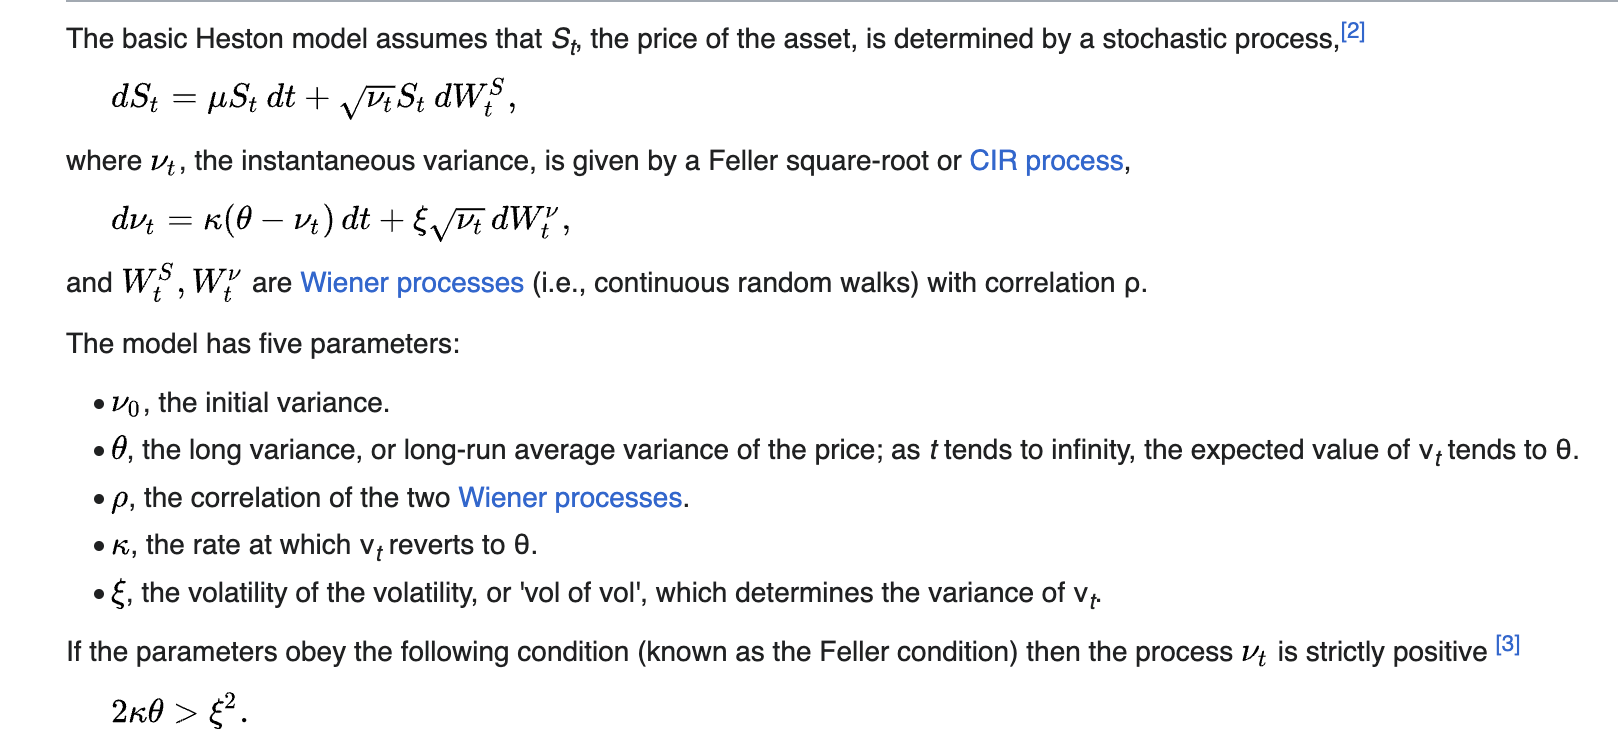

In [2]:
# Generate the price of a American call option using the Finite Difference Method with the Heston model
def americancall_finite_difference(s0, m, T, r, q, v0, theta, kappa, sigma, rho):
    '''
    s0: Spot price at t=0
    m: Moneyness
    T: Time to maturity of the option
    r: Risk-free interest rate
    q: Dividend yield of the underlying asset
    v0: Initial volatility of the Heston mode
    theta: Mean reversion speed of the Heston model
    kappa: Mean reversion level of the Heston model
    sigma: Volatility of the Heston model
    rho: Correlation between the asset price and volatility processes
    '''

    # Parameters
    K = s0 * m    # Strike price of the option
    option_type = ql.Option.Call

    # Set up the option
    today = ql.Date.todaysDate()
    expiry_date = today + ql.Period(f"{int(T*365)}d")
    am_exercise = ql.AmericanExercise(earliestDate=today, latestDate=expiry_date)

    option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, K), am_exercise)

    # Set up the Heston model
    heston_process = ql.HestonProcess(
      ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed())),
      ql.YieldTermStructureHandle(ql.FlatForward(today, q, ql.Actual365Fixed())),
      ql.QuoteHandle(ql.SimpleQuote(s0)),
      v0, kappa, theta, sigma, rho
      )
    heston_model = ql.HestonModel(heston_process)

    tGrid, xGrid, vGrid = 100,100,50#200, 200, 100
    dampingSteps = 0
    fdScheme = ql.FdmSchemeDesc.Hundsdorfer()#ql.FdmSchemeDesc.ModifiedCraigSneyd()
    
    # Calculate the option price using the Heston model with Finite Difference
    heston_engine = ql.FdHestonVanillaEngine(heston_model, tGrid, xGrid, vGrid, dampingSteps, fdScheme)
    option.setPricingEngine(heston_engine)
#     option.enableExtrapolation()
#     print(dir(am_exercise))
#     print('s0:',s0,'m:', m, 'T:', T, 'r:', r, 'q:', q, 'v0:', v0, 'theta:', theta, 'kappa:', kappa, 'sigma:', sigma, 'rho:', rho)
    try:
        return option.NPV()
    except:
        return -1.

# Test
out = americancall_finite_difference(100, 1.05, 2, 0.05, 0.1, 0.05, 0.25, 1.0, 0.5, -0.5)
out

13.347094274405142

In [3]:
n = 25000    # Number of parameters
#Because we will comepare the option prices obtained  from different pricing models (BSM with binomial and Heston)
#We don't need m, T, r, q, v0 as we already generated from the previous assignment.

# Market Parameter
s0 = np.ones(n) * 100
K = np.random.uniform(90, 110, n)
T = np.random.uniform(0.1, 1., n)
r = np.random.uniform(0.01, 0.06, n)
q = np.random.uniform(0.01, 0.03, n)

# Heston Parameters
v0      = np.random.uniform(0.2, 0.5, n)
theta   = np.random.uniform(0.01, 1.0, n)
kappa   = np.random.uniform(0.01, 1.0, n)
sigma   = np.random.uniform(0.01, 1.0, n)
rho     = np.random.uniform(-0.9, 0.9, n)

In [4]:
df = pd.DataFrame({'s0':s0,
              'K': K,
              'T': T,
              'r': r,
              'q': q,
              'v0': v0,
              'theta': theta,
              'kappa': kappa,
              'sigma': sigma,
              'rho': rho})
df['m'] = df['K']/df['s0']
#Feller Condition
# df = df[2*df['kappa']*df['theta']>df['sigma']**2]
df

s0           K         T         r         q        v0     theta  \
0      100.0   99.844262  0.888432  0.032247  0.018597  0.224017  0.472273   
1      100.0  109.766223  0.465272  0.048971  0.023165  0.421364  0.267013   
2      100.0  102.601371  0.831885  0.044449  0.027530  0.472334  0.445864   
3      100.0   94.340697  0.910262  0.059591  0.024178  0.402194  0.122668   
4      100.0  109.109558  0.273804  0.039549  0.016376  0.423731  0.361647   
...      ...         ...       ...       ...       ...       ...       ...   
24995  100.0   95.076387  0.690858  0.033020  0.023040  0.458511  0.012179   
24996  100.0  106.281263  0.113191  0.053137  0.025119  0.311487  0.299311   
24997  100.0   94.227591  0.179206  0.056422  0.028913  0.209519  0.543858   
24998  100.0   99.075157  0.326732  0.034479  0.015407  0.223277  0.205287   
24999  100.0   95.142493  0.566738  0.016469  0.016366  0.385507  0.758901   

          kappa     sigma       rho         m  
0      0.471898  0.657150 -0.421618  0.998443  
1      0.561416  0.185761 -0.525821  1.097662  
2      0.651517  0.989478 -0.214159  1.026014  
3      0.229830  0.199131 -0.848383  0.943407  
4      0.898610  0.656630 -0.052286  1.091096  
...         ...       ...       ...       ...  
24995  0.934833  0.967838  0.510788  0.950764  
24996  0.203236  0.888241  0.896120  1.062813  
24997  0.601468  0.814383  0.547960  0.942276  
24998  0.575709  0.503997 -0.270640  0.990752  
24999  0.556516  0.669507  0.617129  0.951425  

[25000 rows x 11 columns]

 Feller Condition: Heston parameters have to satisfy $2\kappa\theta > \sigma^2$

In [5]:
%%time
df['call_price'] = df.apply(lambda x: americancall_finite_difference(x['s0'],
                                                           x['m'],
                                                           x['T'], 
                                                           x['r'], 
                                                           x['q'], 
                                                           x['v0'], 
                                                           x['theta'], 
                                                           x['kappa'], 
                                                           x['sigma'], 
                                                           x['rho']), 
                            axis=1)

CPU times: total: 9min 5s
Wall time: 24min 4s


In [6]:
df

s0           K         T         r         q        v0     theta  \
0      100.0   99.844262  0.888432  0.032247  0.018597  0.224017  0.472273   
1      100.0  109.766223  0.465272  0.048971  0.023165  0.421364  0.267013   
2      100.0  102.601371  0.831885  0.044449  0.027530  0.472334  0.445864   
3      100.0   94.340697  0.910262  0.059591  0.024178  0.402194  0.122668   
4      100.0  109.109558  0.273804  0.039549  0.016376  0.423731  0.361647   
...      ...         ...       ...       ...       ...       ...       ...   
24995  100.0   95.076387  0.690858  0.033020  0.023040  0.458511  0.012179   
24996  100.0  106.281263  0.113191  0.053137  0.025119  0.311487  0.299311   
24997  100.0   94.227591  0.179206  0.056422  0.028913  0.209519  0.543858   
24998  100.0   99.075157  0.326732  0.034479  0.015407  0.223277  0.205287   
24999  100.0   95.142493  0.566738  0.016469  0.016366  0.385507  0.758901   

          kappa     sigma       rho         m  call_price  
0      0.471898  0.657150 -0.421618  0.998443   18.427238  
1      0.561416  0.185761 -0.525821  1.097662   13.569919  
2      0.651517  0.989478 -0.214159  1.026014   21.879363  
3      0.229830  0.199131 -0.848383  0.943407   25.770744  
4      0.898610  0.656630 -0.052286  1.091096    9.895316  
...         ...       ...       ...       ...         ...  
24995  0.934833  0.967838  0.510788  0.950764   20.513338  
24996  0.203236  0.888241  0.896120  1.062813    5.300659  
24997  0.601468  0.814383  0.547960  0.942276   10.926112  
24998  0.575709  0.503997 -0.270640  0.990752   11.175703  
24999  0.556516  0.669507  0.617129  0.951425   21.462213  

[25000 rows x 12 columns]

In [7]:
df[df['call_price']==-1]

Empty DataFrame
Columns: [s0, K, T, r, q, v0, theta, kappa, sigma, rho, m, call_price]
Index: []

In [8]:
df.to_csv('american_option_price_with_heston.csv', index=False)